In [1]:
!python --version
%pip install ../ # Use local jaxDSP package rather than published one.

Python 3.12.3
Processing /Users/khiner/Development/jaxdsp
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for jaxdsp: filename=jaxdsp-0.3.1-py3-none-any.whl size=22243 sha256=10dedf0c553e72734bd63964ab1c6d20e644af0fe854b9f2cb64d8e65c6be2b4
  Stored in directory: /private/var/folders/ml/r9zrbg2s0hq7cyxx40fw_k800000gn/T/pip-ephem-wheel-cache-7abm0px6/wheels/f1/a5/b7/313c75bc0afa33627e970f8339fd2e2d68a1dc70b987148cef
Successfully built jaxdsp
  Attempting uninstall: jaxdsp
    Found existing installation: jaxdsp 0.3.1
    Uninstalling jaxdsp-0.3.1:
      Successfully uninstalled jaxdsp-0.3.1
Note: you may need to restart the kernel to use updated packages.


In [2]:
import jax.numpy as jnp
from scipy import signal
import numpy as np
import time

from jaxdsp import training, processor_graph
from jaxdsp.processors import fir_filter, iir_filter, clip, delay_line, biquad_lowpass, lowpass_filter, allpass_filter, freeverb, sine_wave, processors_to_graph_config, processor_names_from_graph_config
from jaxdsp.plotting import plot_train, plot_optimization
from jaxdsp.loss import LossOptions
from jaxdsp.params import params_to_float

In [3]:
num_train = 100

buffer_size = 44100
Xs_random = np.random.randn(num_train, buffer_size)
Xs_chirp = np.array(np.split(signal.chirp(np.linspace(0.0, num_train, num_train * buffer_size), f0=10, f1=1000, t1=num_train), num_train))

default_loss_opts = LossOptions(
    weights={"sample": 1.0},
    distance_types={"sample": "L2"},
)
# NOTE (for blog post/paper):
# Changing the STFT window can have dramatic effects on the optimization.
# E.g. with the sines->filter test below, changing `stft_window` from the default ('hann') to 'hamming' or 'bartlett' makes it not succeed.
spectral_loss_opts = LossOptions(
    weights={"cumsum_freq": 1.0},
    distance_types={"frequency": "L1"},
#    stft_window="hamming",
)
optimizer_opts = {"name": "Adam"}

In [4]:
def evaluate_processors(processors, params_target, loss_opts=default_loss_opts, optimization_opts=optimizer_opts, Xs=Xs_chirp, num_batches=100, reference_fn=None, plot_loss_history=True, plot_params_history=True, title=None):
    graph_config = processors_to_graph_config(processors)
    processor_names = processor_names_from_graph_config(graph_config)
    trainer = training.IterativeTrainer(graph_config, loss_opts, optimization_opts, track_history=True)
    carry_target = (params_target, trainer.state)
    start = time.time()
    for i in range(num_batches):
        # X = Xs[i % Xs.shape[0]]
        X = Xs[np.random.choice(Xs.shape[0])]
        carry_target, Y_target = processor_graph.tick_buffer(carry_target, X, processor_names)
        trainer.step(X, Y_target)

    params_estimated = params_to_float(trainer.params)
    print('Train time: {:.3E} s'.format(time.time() - start))
    print('Loss: {:.3E}'.format(trainer.loss))
    print('Estimated params: ', params_estimated)

    X_eval = Xs[0]
    _, Y_estimated = processor_graph.tick_buffer((params_estimated, trainer.state), X_eval, processor_names)
    _, Y_target = processor_graph.tick_buffer(carry_target, X_eval, processor_names)
    Y_reference = reference_fn(X_eval, carry_target[0]) if reference_fn is not None else None

    plot_train(trainer, params_target, X_eval, Y_target, Y_estimated, Y_reference, title=title, plot_loss_history=plot_loss_history, plot_params_history=plot_params_history)

Train time: 1.396E+00 s
Loss: 8.818E-05
Estimated params:  [[{'damp': 0.5044617652893066, 'feedback': 0.49871793389320374}]]


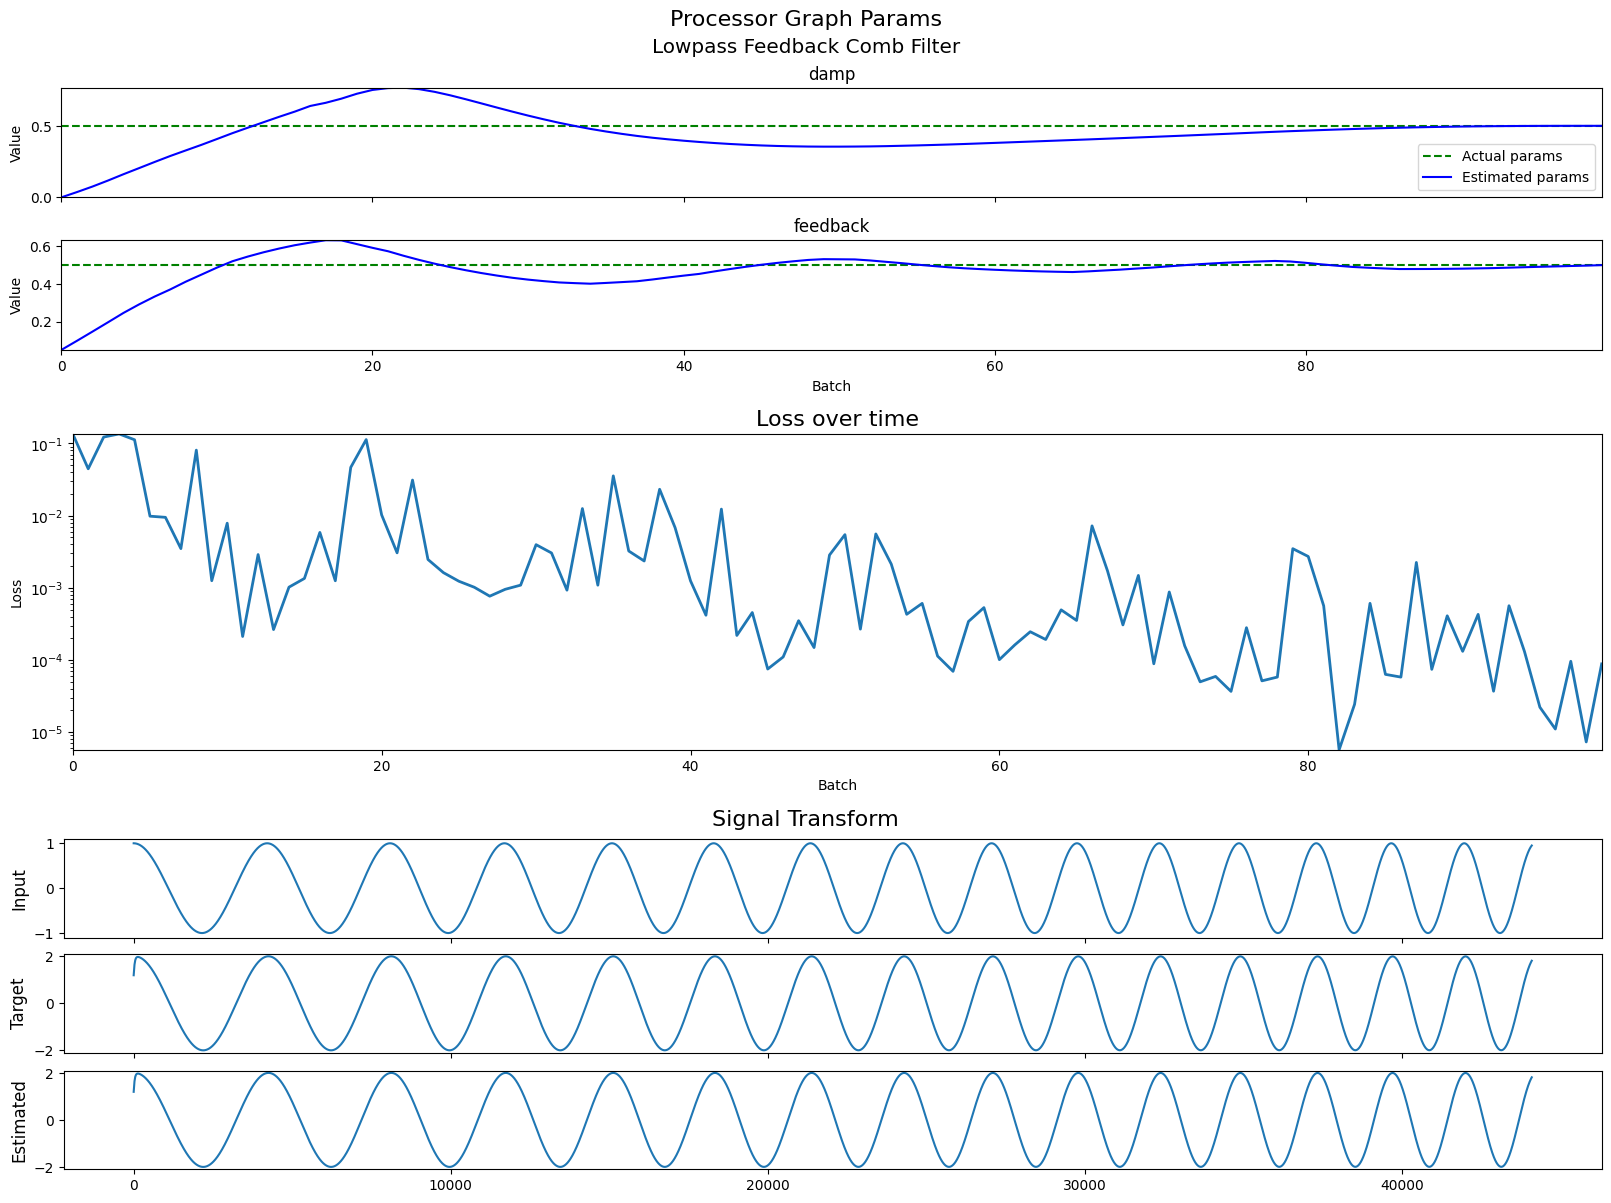

In [5]:
evaluate_processors([[lowpass_filter]], [[{"feedback": 0.5, "damp": 0.5}]])

Train time: 3.548E+00 s
Loss: 1.811E-02
Estimated params:  [[{'frequency_hz': 399.5037536621094}]]


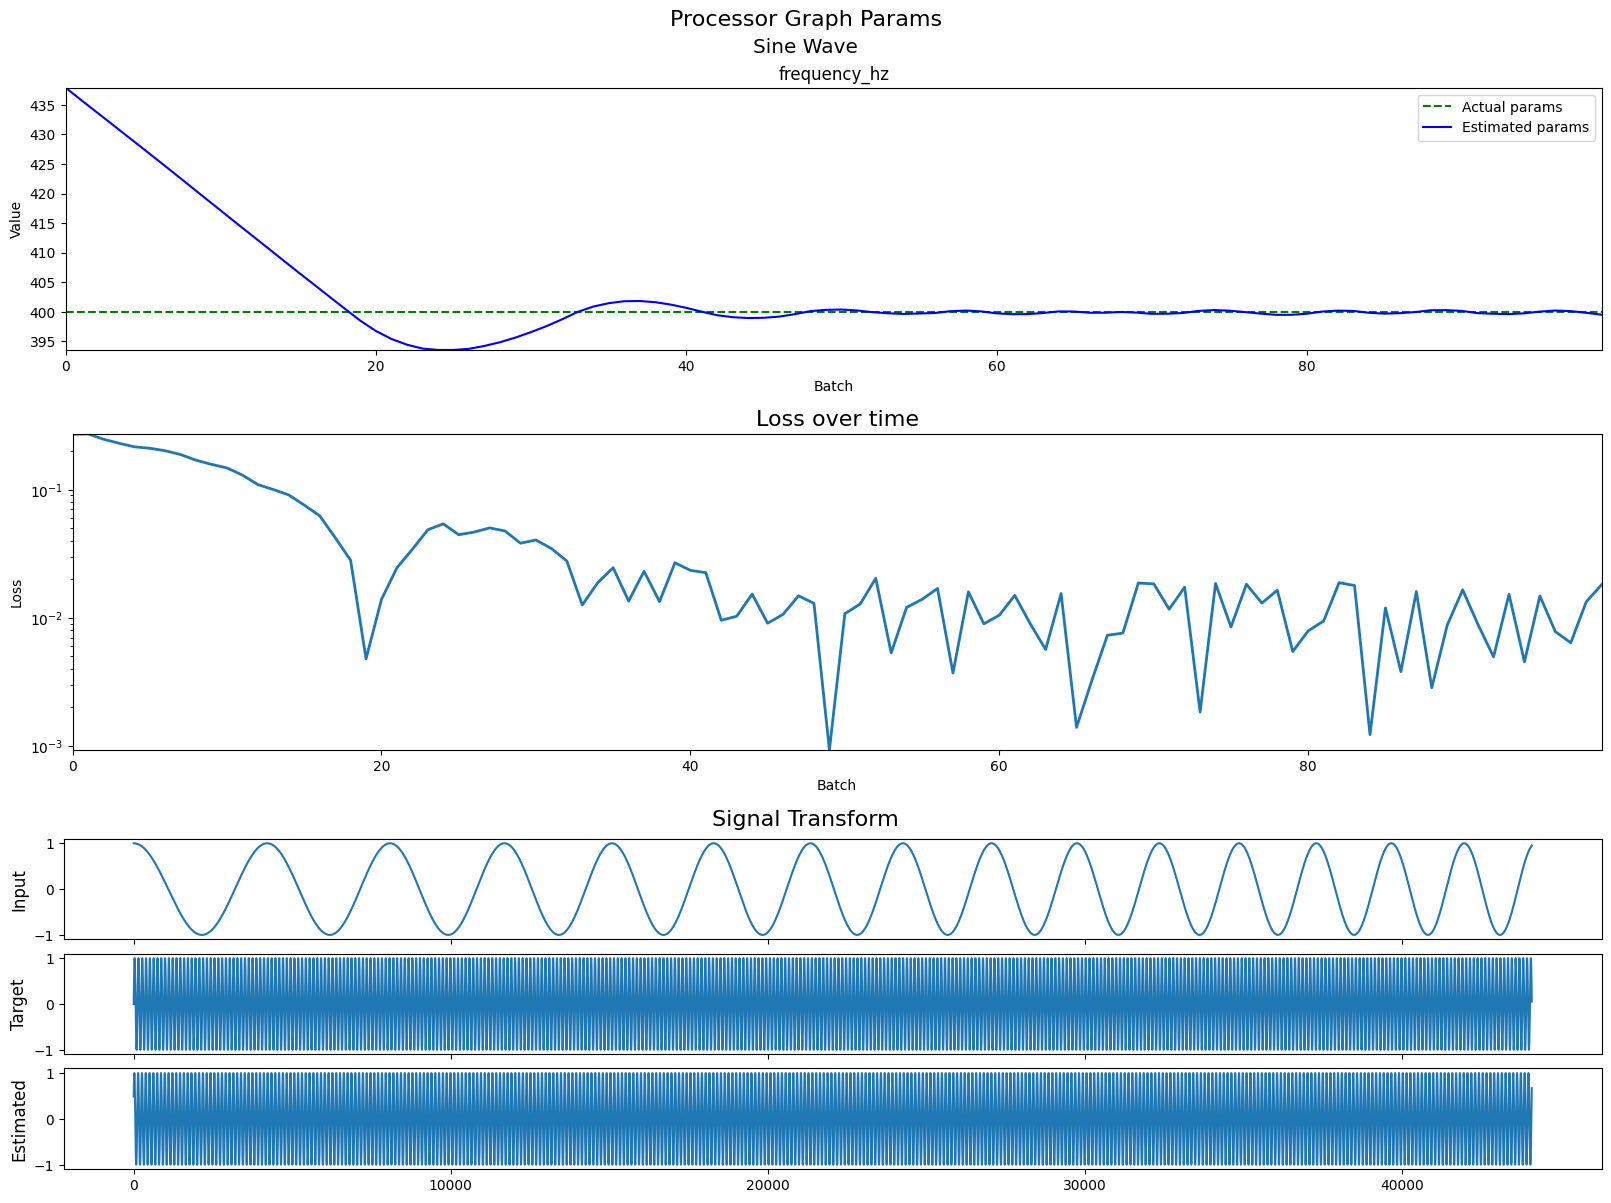

In [6]:
evaluate_processors([[sine_wave]], [[{"frequency_hz": 400.0}]], loss_opts=spectral_loss_opts, optimization_opts={'name': 'Adam', 'params': {'step_size': 0.0003}})

Train time: 3.040E+01 s
Loss: 6.539E-06
Estimated params:  [[{'damp': 0.49316754937171936, 'dry': 0.0, 'room_size': 0.5005280375480652, 'wet': 0.3006741404533386, 'width': 1.0}]]


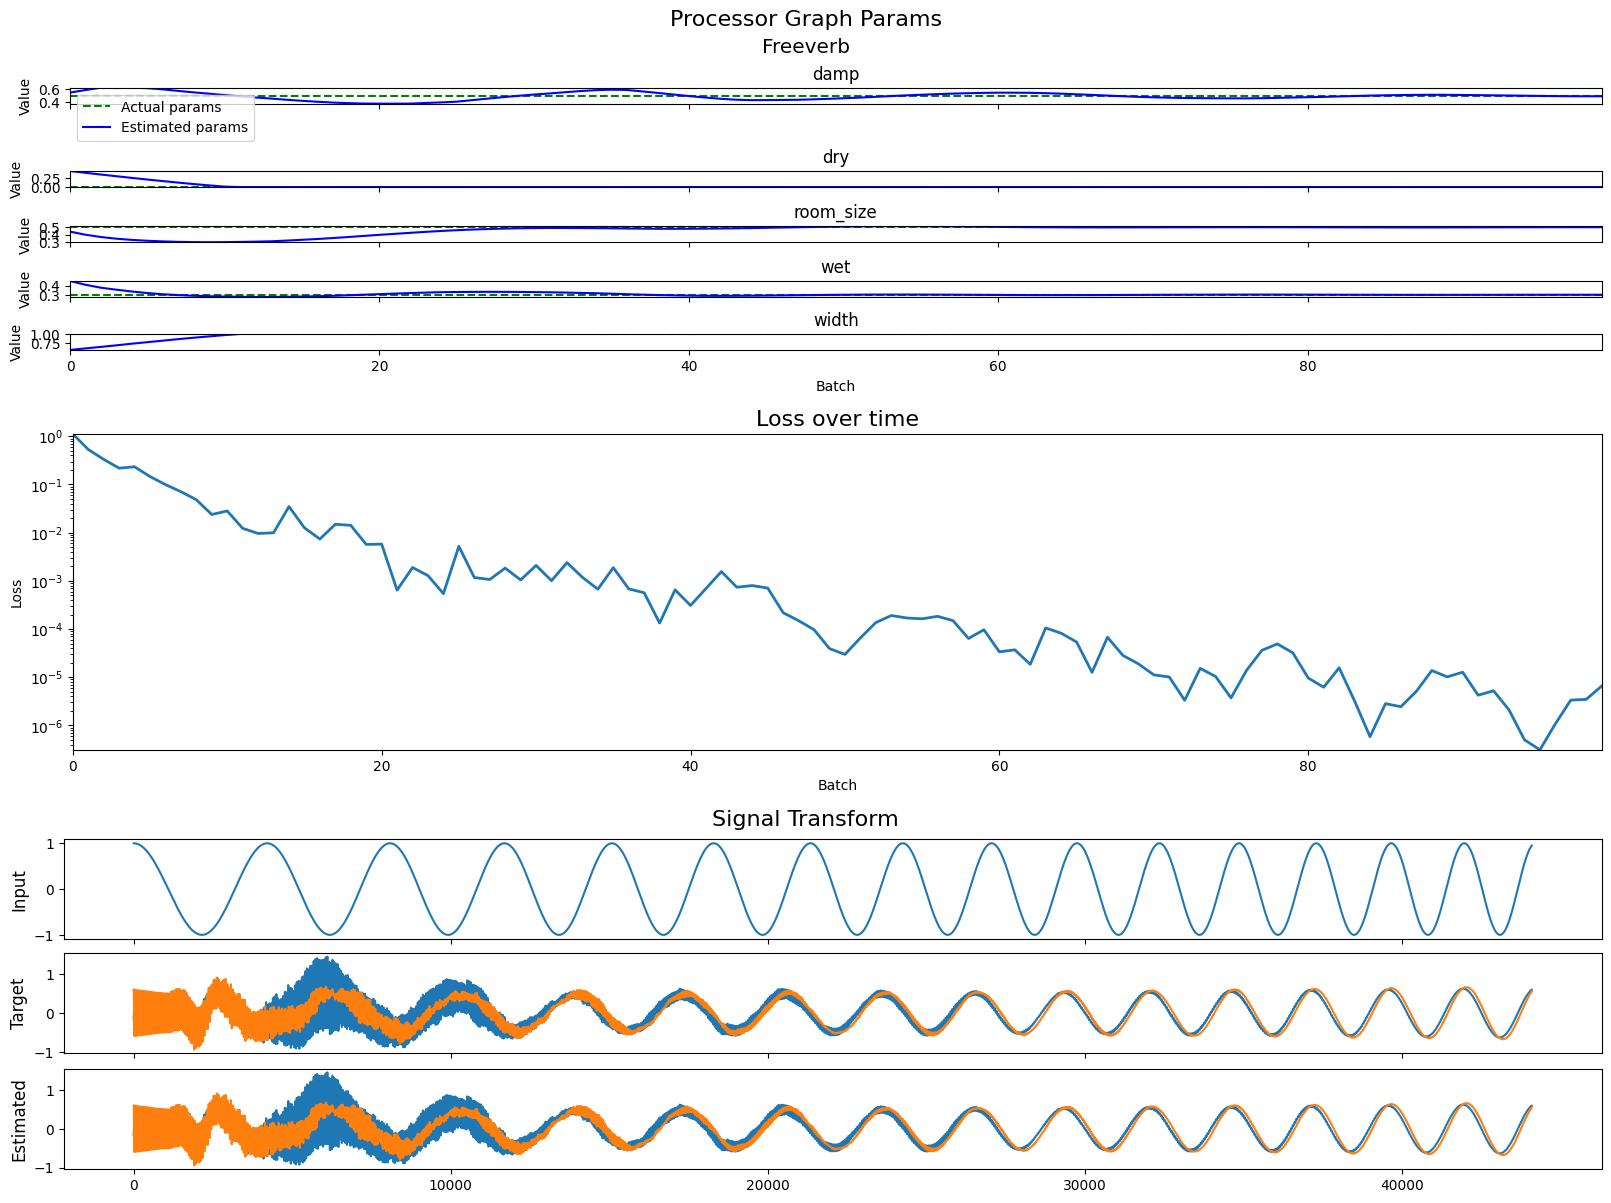

In [7]:
evaluate_processors([[freeverb]], [[{
    'wet': 0.3,
    'dry': 0.0,
    'width': 1.0,
    'damp': 0.5,
    'room_size': 0.5,
}]])

Train time: 3.526E-01 s
Loss: 4.311E-05
Estimated params:  [[{'feedback': 0.4921307861804962}]]


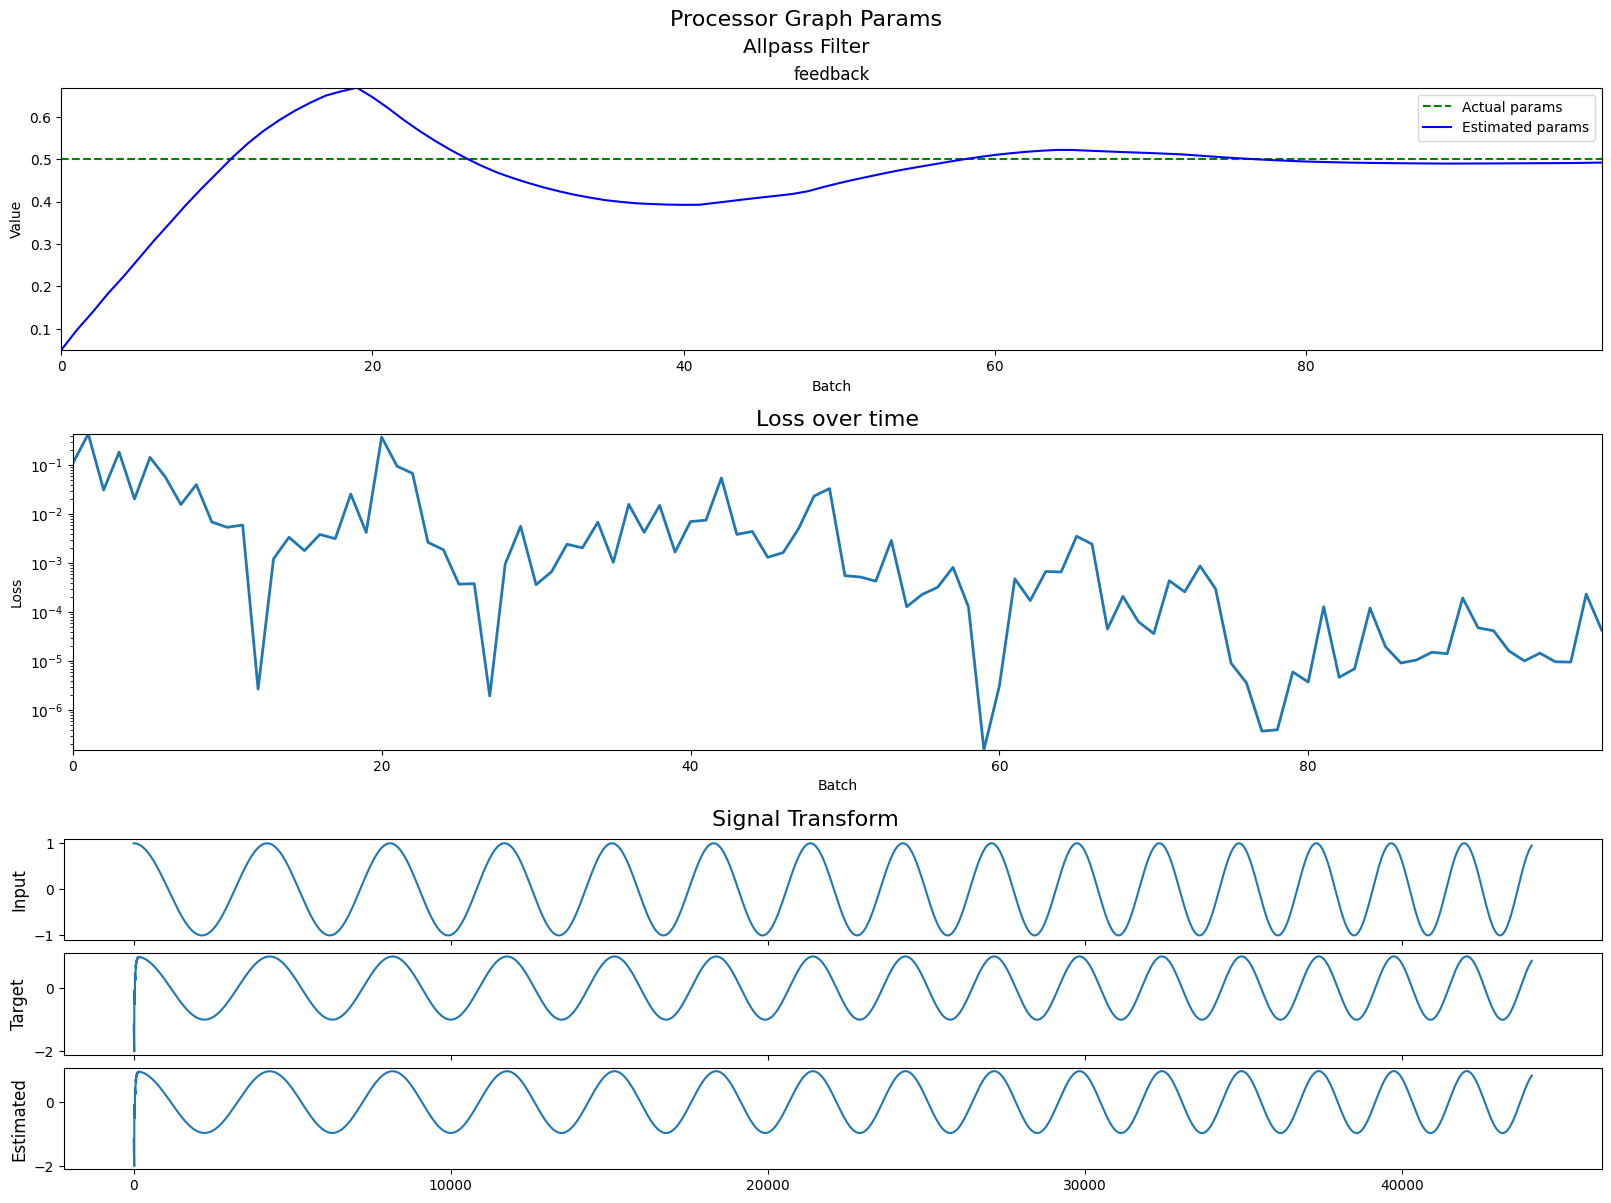

In [8]:
evaluate_processors([[allpass_filter]], [[{'feedback': 0.5}]])

Train time: 2.446E-01 s
Loss: 1.512E-05
Estimated params:  [[{'B': Array([0.09927244, 0.6990015 , 0.49863815, 0.60293305, 0.        ],      dtype=float32)}]]


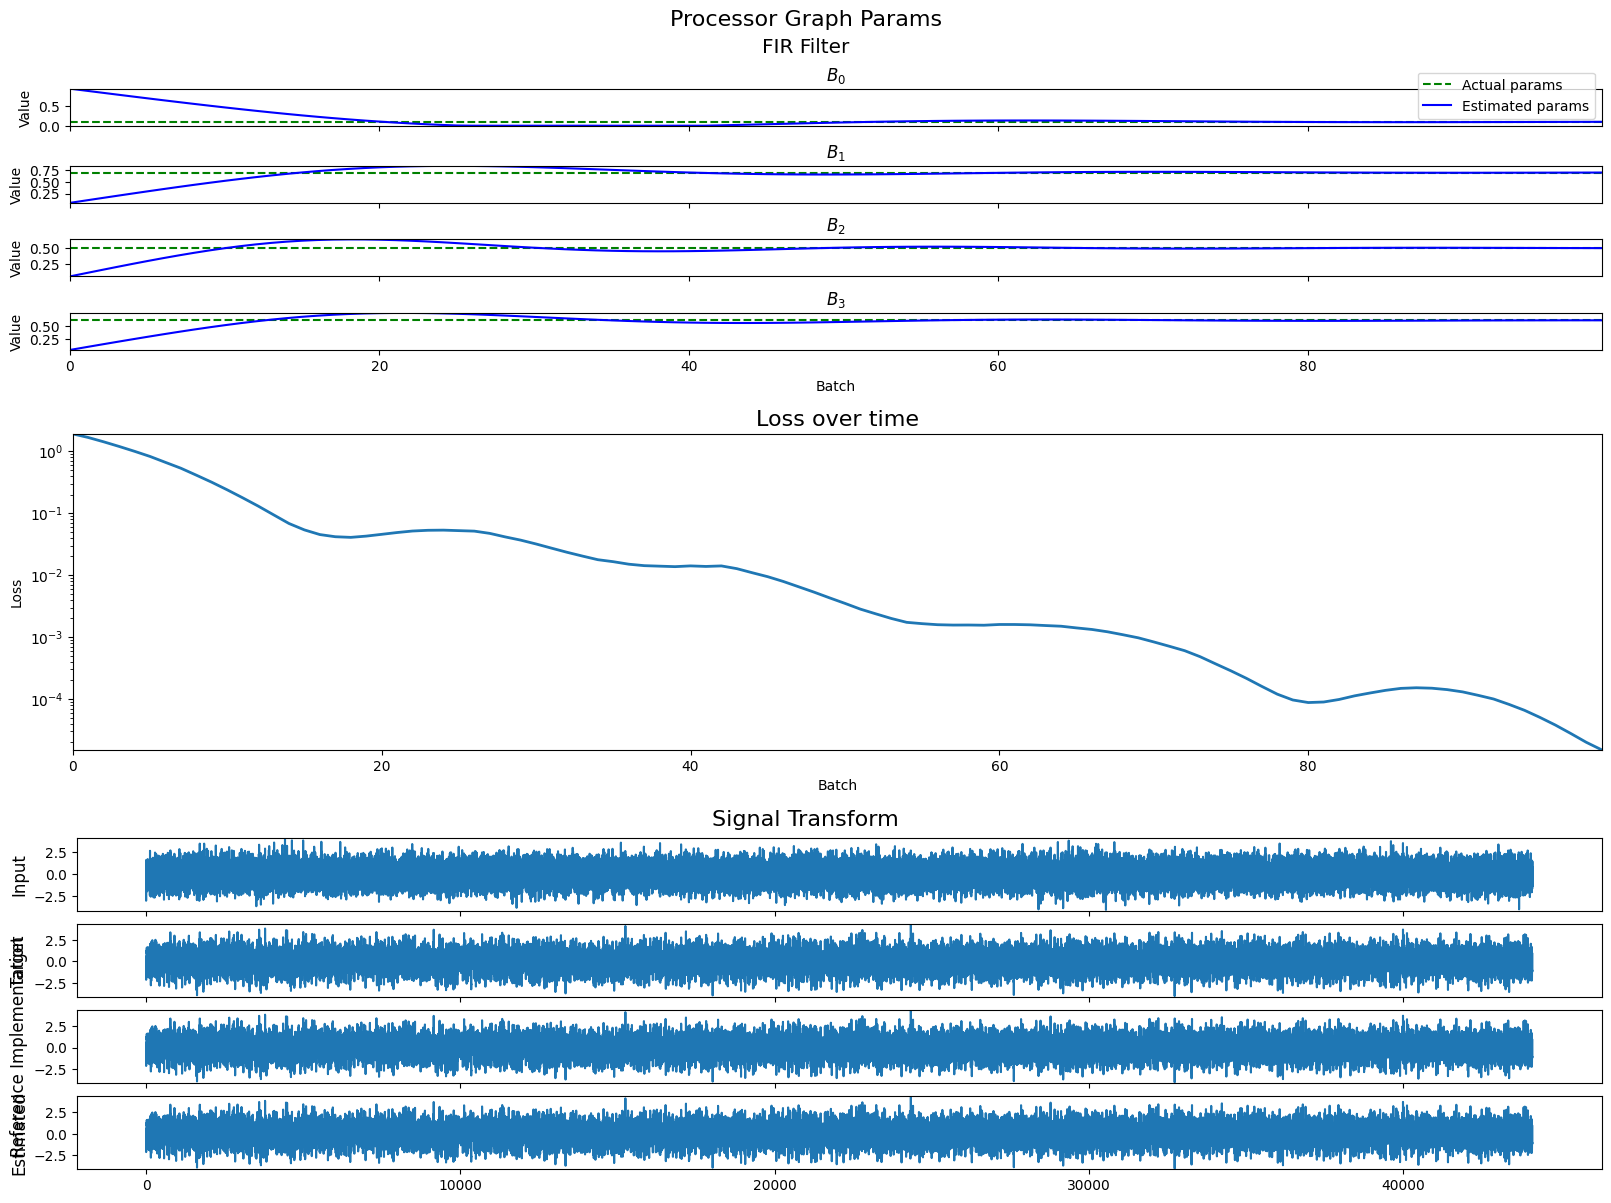

In [9]:
reference_fn = lambda X, params: signal.lfilter(params[0][0]['B'], [1.0], X)
evaluate_processors([[fir_filter]], [[{'B': jnp.array([0.1, 0.7, 0.5, 0.6])}]], Xs=Xs_random, reference_fn=reference_fn)

Train time: 3.880E-01 s
Loss: 2.469E-03
Estimated params:  [[{'A': Array([1.        , 0.04624543, 0.2932132 , 0.06839322, 0.        ],      dtype=float32), 'B': Array([0.09481315, 0.37933844, 0.5595973 , 0.33907038, 0.        ],      dtype=float32)}]]


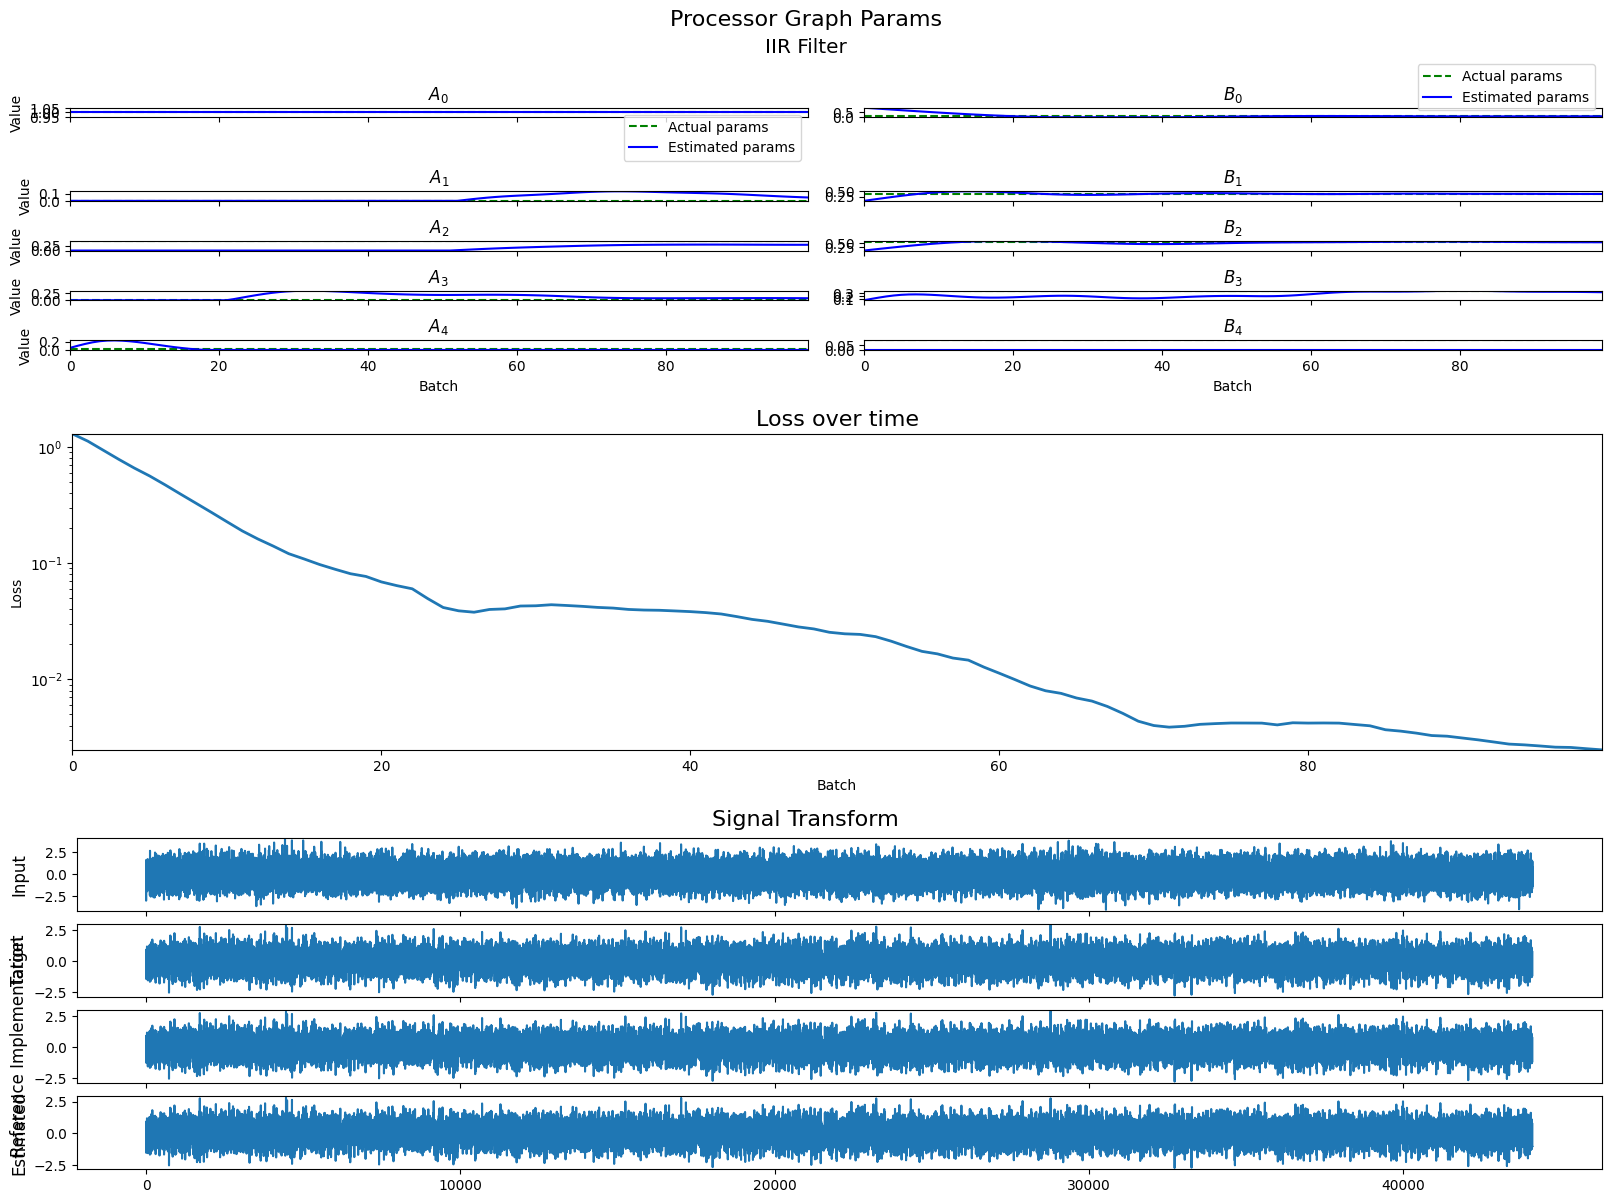

In [10]:
from scipy import signal

B_target, A_target = signal.butter(4, 0.5, "low")
iir_filter_target_params = {
    'B': B_target,
    'A': A_target,
}
reference_fn = lambda X, params: signal.lfilter(params[0][0]['B'], params[0][0]['A'], X)
evaluate_processors([[iir_filter]], [[iir_filter_target_params]], Xs=Xs_random, reference_fn=reference_fn)

Train time: 1.923E-01 s
Loss: 3.955E-07
Estimated params:  [[{'max': 0.5012712478637695, 'min': -0.5013042688369751}]]


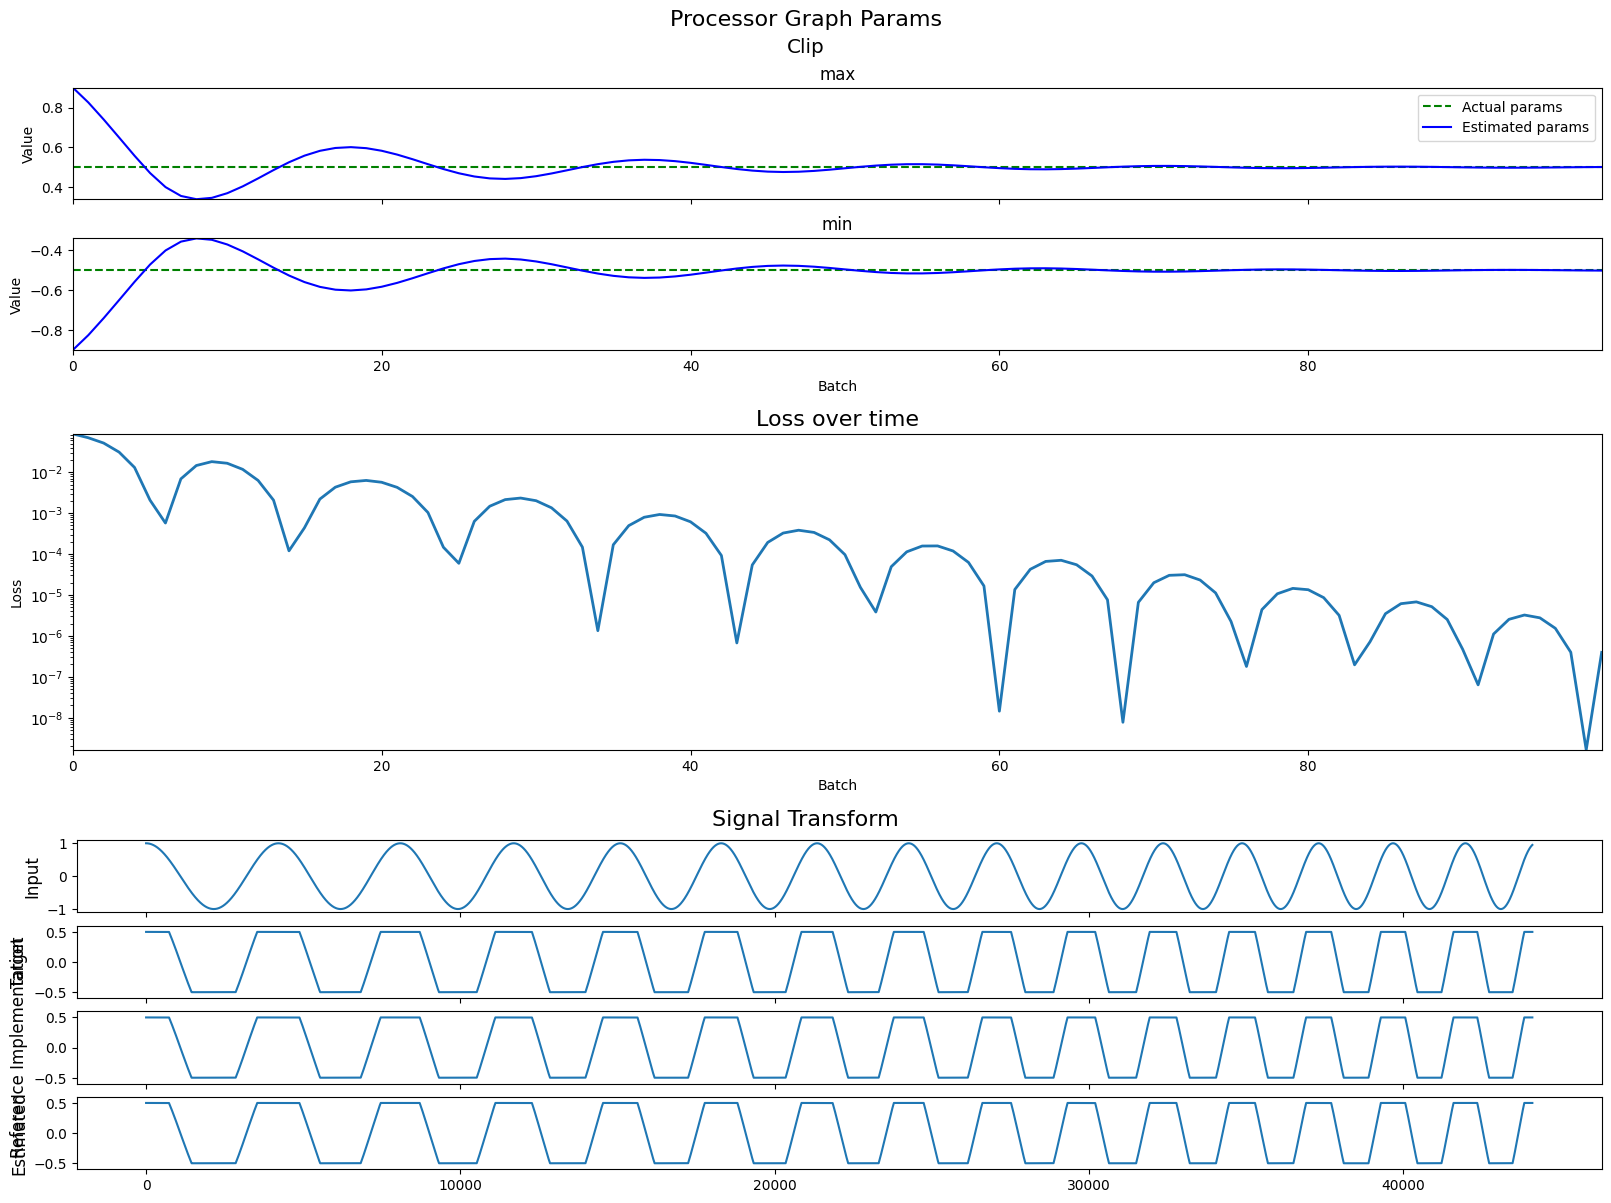

In [11]:
clip_target_params = {'min': -0.5, 'max': 0.5}
reference_fn = lambda X, params: np.clip(X, params[0][0]['min'], params[0][0]['max'])
evaluate_processors([[clip]], [[clip_target_params]], reference_fn=reference_fn)

Train time: 1.532E+00 s
Loss: 2.444E-06
Estimated params:  [[{'A': Array([1.       , 0.359542 , 0.1739107, 0.       , 0.       ], dtype=float32), 'B': Array([0.75446135, 0.        , 0.09182197, 0.26016018, 0.43124613],      dtype=float32)}], [{'max': 0.5000041723251343, 'min': -0.5000055432319641}]]


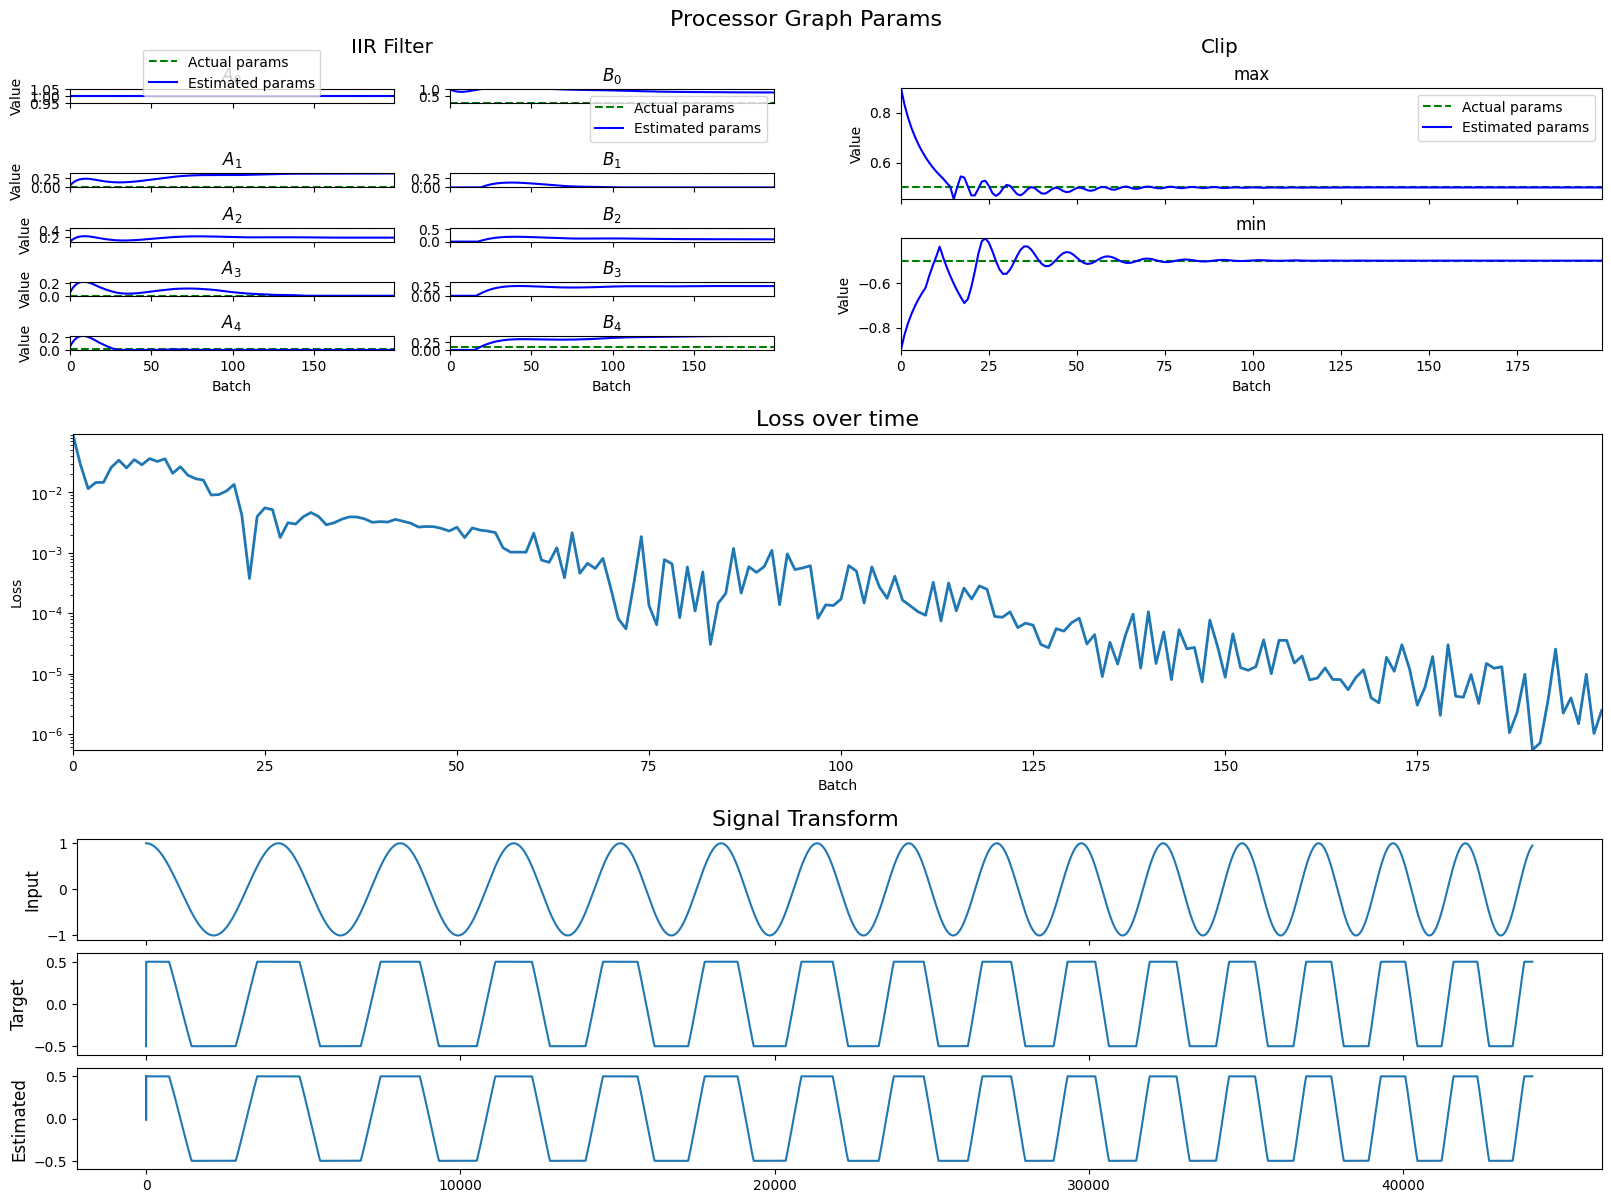

In [12]:
evaluate_processors([[iir_filter], [clip]], [[iir_filter_target_params], [clip_target_params]], num_batches=200)

Train time: 1.237E+01 s
Loss: 7.615E-02
Estimated params:  [[{'frequency_hz': 401.2463073730469}, {'frequency_hz': 598.8041381835938}], [{'feedback': 0.4969979226589203}]]


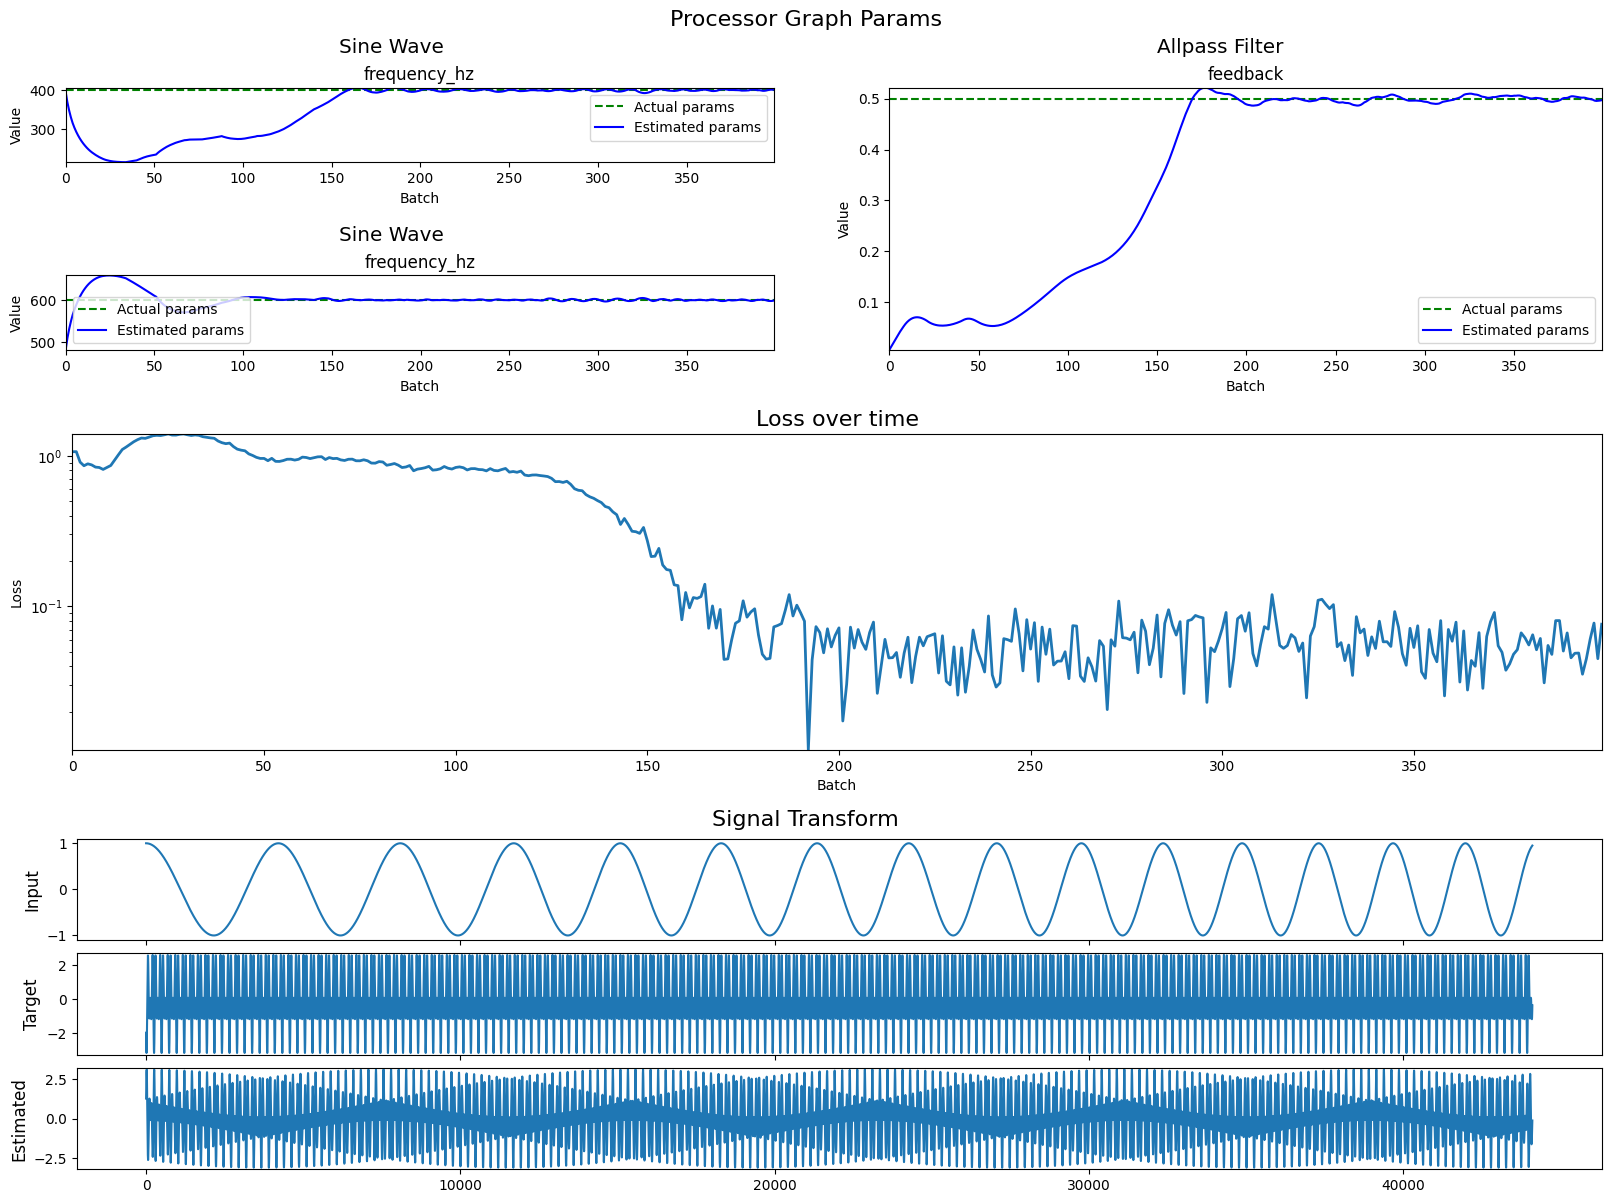

In [13]:
evaluate_processors([[sine_wave, sine_wave], [allpass_filter]], [[{'frequency_hz': 400.0}, {'frequency_hz': 600.0}], [{'feedback': 0.5}]], loss_opts=spectral_loss_opts, optimization_opts={'name': 'Adam', 'params': {'step_size': 0.006}}, num_batches=400)